In [1]:
%matplotlib inline
from setting.matplotlib_ import *
from setting.tools import *

In [2]:
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
PCSE version: 5.5.0


## Loading environment data

In [3]:
target_env = pd.read_csv('./data/pap_env_RDA_open.csv', skiprows=1, header=None)
target_env.loc[:, 0] = pd.DatetimeIndex(target_env.loc[:, 0])
template = pd.read_excel('./data/data_template.xls', header=None)

In [4]:
target_env = pd.concat([template.loc[:11], target_env], axis=0)

In [5]:
target_env.to_excel('./data/pap_env_processed.xls', index=False, header=False)

/tmp/ipykernel_256749/2866564418.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  target_env.to_excel('./data/pap_env_processed.xls', index=False, header=False)


## Loading growth data

In [6]:
target_output = pd.read_csv(f'./data/pap_grw_RDA_open.csv', index_col='date')
target_output['LAI'] = (target_output['lefCunt']*target_output['lefLt']*target_output['lefBt'])/1000
target_output.index = pd.DatetimeIndex(target_output.index)

In [7]:
target_output.loc[target_output['LAI'] == 0, 'LAI'] = np.nan
target_output.loc[:, 'LAI'] = target_output.loc[:, 'LAI'].ffill()
target_output = target_output.loc[~target_output.loc[:, 'LAI'].isna()]

In [8]:
target_output = target_output.loc[:, ['LAI', 'cum_harvest']]
target_output.columns = ['LAI', 'TWSO']

In [9]:
CROP_NAME = 'soybean'
VARIETY_NAME = 'Soybean_906'
START_DATE = str(pd.Timestamp('2018-03-23').date()) # starting date was deleted because of dropna
END_DATE = str(target_output.index[-1].date())
CULT_PERIOD = (pd.Timestamp(END_DATE)- pd.Timestamp(START_DATE)).days
print(f'from {START_DATE} to {END_DATE}: {CULT_PERIOD} days')

from 2018-03-23 to 2018-09-21: 182 days


## Input data for WOFOST

In [10]:
cropd = YAMLCropDataProvider()
soild = DummySoilDataProvider()
sited = WOFOST72SiteDataProvider(WAV=50, CO2=360.)
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [11]:
# Agromanagement for the custom data
agro_yaml = f"""
- {START_DATE}:
    CropCalendar:
        crop_name: {CROP_NAME}
        variety_name: {VARIETY_NAME}
        crop_start_date: {START_DATE}
        crop_start_type: emergence
        crop_end_date: {END_DATE}
        max_duration: {CULT_PERIOD}
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml, Loader=yaml.FullLoader)

In [12]:
wdp = ExcelWeatherDataProvider('./data/pap_env_processed.xls')

## WOFOST Initialization

In [13]:
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()

## Parameter selection

In [14]:
fixed_params = {'TBASE':18, 'SPAN':400}

이미 알고 있는 파라미터를 고정할 수 있습니다.

In [15]:
target_param = 'TDWI'
target_obj = ['TWSO', 'LAI']
params_range = [0, 2000]
step_size = 200
for_params = np.linspace(params_range[0], params_range[-1], int(params_range[-1]/step_size)+1)

In [16]:
# target_param = 'AMAXTB'
# target_obj = ['TWSO', 'LAI']
# params_range = [0, 100]
# step_size = 20

# temp_list = np.linspace(params_range[0], params_range[-1], int(params_range[-1]/step_size)+1)
# for_params = []
# for _ in temp_list:
#     for_params.append([0.0, _, 2.0, _])

목표로 하는 파라미터를 설정하고, 탐색하고자 하는 범위와 간격을 정합니다.

In [17]:
origin_value = {}
origin_value[target_param] = params._cropdata[target_param]

# Repeat

In [18]:
twso_result = []
lai_result = []
losses = []
print(f'For {target_param}: {params_range[0]}-{params_range[-1]} for {step_size}')
for PARAM in for_params:
    objfunc_calculator = ObjectiveFunctionCalculator([target_param], target_obj, params, wdp, agro, target_output)
    _ = objfunc_calculator({target_param: PARAM})

    twso_result.append(objfunc_calculator.df_sim.TWSO)
    lai_result.append(objfunc_calculator.df_sim.LAI)
    losses.append(objfunc_calculator.loss)
    gc.collect()

For TDWI: 0-2000 for 200


In [19]:
losses = np.array(losses)
sorted_index = np.argsort(losses)

In [20]:
twso_result = pd.concat(twso_result, axis=1)
lai_result = pd.concat(lai_result, axis=1)

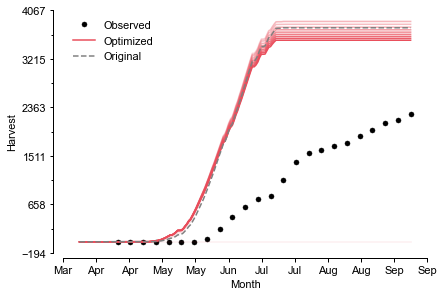

In [21]:
fig = plt.figure(figsize=((8/2.54*2), (6/2.54*1.8)))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

obs, = ax.plot(target_output.index, target_output.TWSO, 'o', ms=5, mew=0.5, mec='k', c='k')
for i in range(twso_result.shape[1]):
    opt, = ax.plot(twso_result.index, twso_result.iloc[:, i], c=cmap[0], alpha=(i+1)/twso_result.shape[1])
_ = objfunc_calculator(origin_value)
ori, = ax.plot(objfunc_calculator.df_sim.index, objfunc_calculator.df_sim.TWSO, "--", c='gray')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(LinearLocator(12))
ax.yaxis.set_major_locator(LinearLocator(6))
ax.yaxis.set_minor_locator(LinearLocator(11))
ax.set_xlabel('Month')
ax.set_ylabel('Harvest')

plt.legend(handles=[obs, opt, ori], labels=['Observed', 'Optimized', 'Original'], frameon=False, loc=0)
fig.tight_layout()
plt.show()

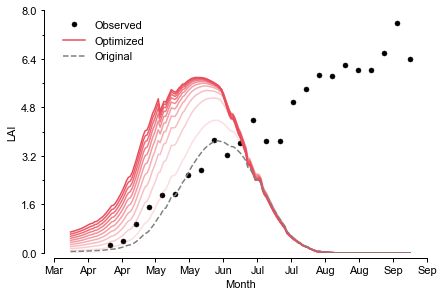

In [22]:
fig = plt.figure(figsize=((8/2.54*2), (6/2.54*1.8)))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

obs, = ax.plot(target_output.index, target_output.LAI, 'o', ms=5, mew=0.5, mec='k', c='k')
for i in range(lai_result.shape[1]):
    opt, = ax.plot(lai_result.index, lai_result.iloc[:, i], c=cmap[0], alpha=(i+1)/lai_result.shape[1])
_ = objfunc_calculator(origin_value)
ori, = ax.plot(objfunc_calculator.df_sim.index, objfunc_calculator.df_sim.LAI, "--", c='gray')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(LinearLocator(12))
ax.yaxis.set_major_locator(LinearLocator(6))
ax.yaxis.set_minor_locator(LinearLocator(11))
ax.set_ybound(0, 8)
ax.set_xlabel('Month')
ax.set_ylabel('LAI')

plt.legend(handles=[obs, opt, ori], labels=['Observed', 'Optimized', 'Original'], frameon=False, loc=0)
fig.tight_layout()
plt.show()